# ESILV Algotrading 2025-26 Capstone project

In this project you will study and implement a cross-asset strategy that use a simple trend following algorithm and try to refine it to improve the performances. The data consists of the daily closing prices of 47 assets of various asset classes. A lot of articles are available on this well known strategy, particularly for futures. Search for example "Commodity Trading Advisors" or ask your favorite AI about "managed futures".

Each section of the notebook contains questions that require text answers and cells that will ask you to develop pieces of code. It will end by more open questions.

Out-of-sample data for years 2023-2025 will be used to validate your strategy and calculate the final Sharpe ratio for period 2010-2025. **It will be made available on 26/01/2026 morning** with the same format as the in-sample data. I strongly recommend that you prepare the code to be executed with the new data without any further optimisation.

**The final notebook shall be submitted by 28/01/2026 midnight.**

## 1- Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
df = pd.read_csv('assets_data_student.csv', parse_dates=True, index_col=[0])
df_daily = df.resample('1d').last().ffill()
log_returns = df_daily.apply(np.log).diff()

In the code above, we first load the data and compute the daily log-returns.

**Q1** Can you describe the advantage of log-returns compared to the linear returns $\frac{S_t}{S_{t-1}}-1$?

Log-returns have several key advantages over linear returns:

1. **Time-additivity**: Log-returns are additive over time periods:
   log(S_t/S_0) = log(S_t/S_{t-1}) + log(S_{t-1}/S_{t-2}) + ... + log(S_1/S_0)
   This makes it easy to compute multi-period returns by simply summing daily log-returns.

2. **Symmetry**: Log-returns treat gains and losses symmetrically. 
   A +10% gain followed by -10% loss doesn't return to original value with linear returns,
   but log-returns handle this more consistently.

3. **Statistical properties**: Log-returns are closer to a normal distribution, which is
   important for many statistical models and risk management calculations.

4. **Numerical stability**: For small returns, log-returns approximate linear returns well,
   but avoid numerical issues with compounding.

5. **Continuous-time finance**: Log-returns naturally connect to continuous-time models
   used in theoretical finance (geometric Brownian motion, Black-Scholes, etc.).


**Q2** What is the effect and the purpose of the 2nd line of code?

This line performs three operations:

1. **resample('1d')**: Resamples the time series to daily frequency ('1d' = 1 day).
   If data has higher frequency (intraday) or irregular timestamps, this standardizes it.

2. **.last()**: For each day, takes the last available value. This is important if there
   are multiple observations per day - we keep the closing price.

3. **.ffill()**: Forward fills missing values. If a date has no data (weekends, holidays),
   it carries forward the last known value. This ensures a complete daily time series
   without gaps, which is essential for time series analysis.

**Purpose**: Create a clean, gap-free daily price series suitable for calculating
daily returns and running trading strategies.


**Q3** Plot in a graph the number of available assets as a function of time.   

In [4]:
available_assets = df_daily.notna().sum(axis=1)
print(available_assets)

Date
2000-01-03    11
2000-01-04    11
2000-01-05    11
2000-01-06    11
2000-01-07    11
              ..
2022-12-26    47
2022-12-27    47
2022-12-28    47
2022-12-29    47
2022-12-30    47
Freq: D, Length: 8398, dtype: int64


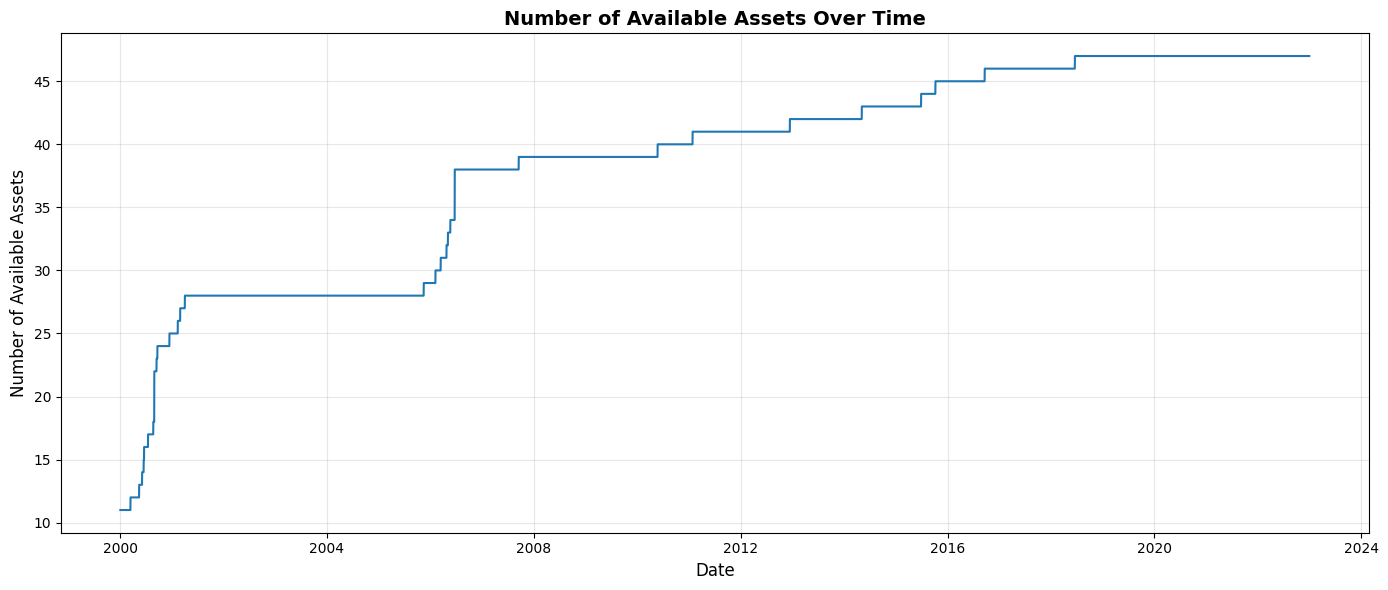

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(available_assets.index, available_assets.values, linewidth=1.5)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Available Assets', fontsize=12)
plt.title('Number of Available Assets Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('q3_available_assets.png', dpi=300, bbox_inches='tight')
plt.show()

**Q4** Using seaborn package, plot the heat map of the correlation matrix for year 2018.

In [6]:
log_returns_2018 = log_returns[log_returns.index.year == 2018]
correlation_matrix_2018 = log_returns_2018.corr()

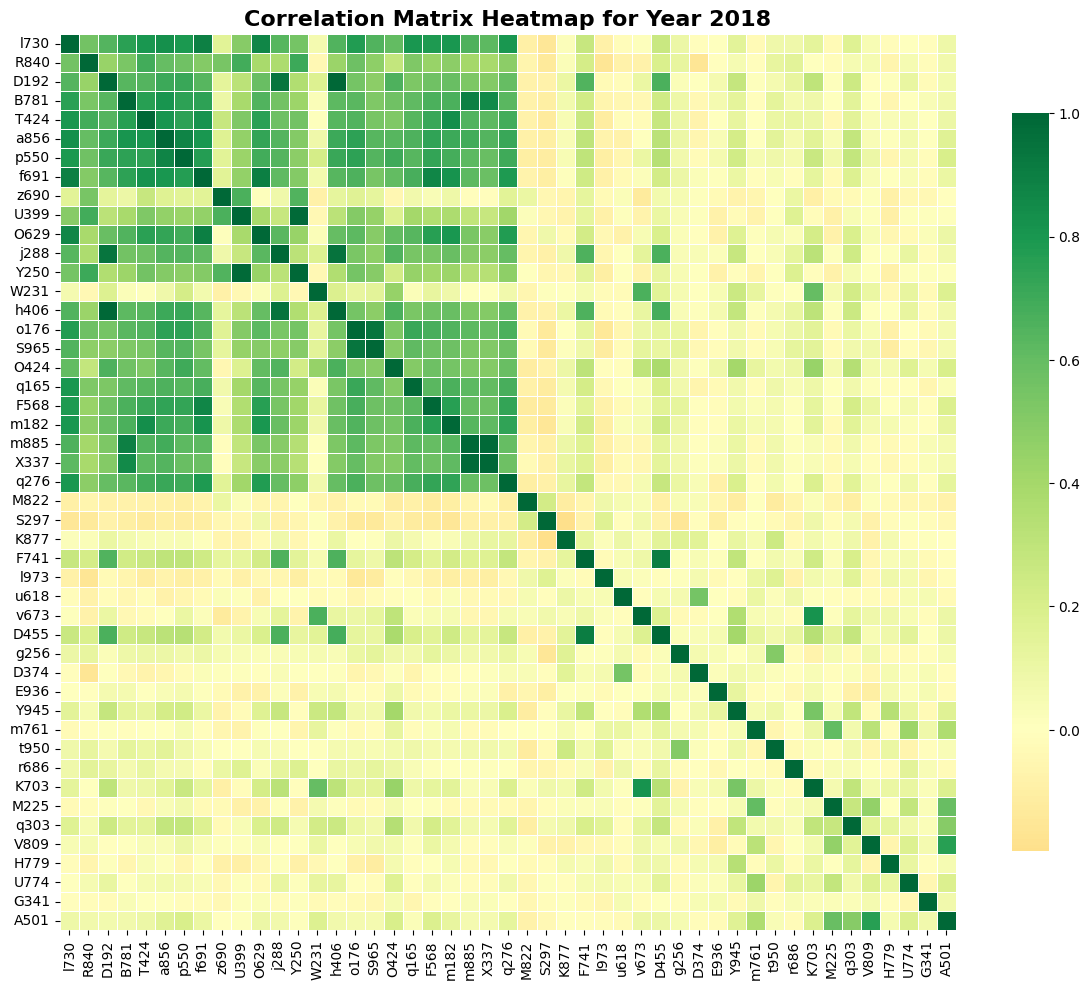

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_2018, annot=False, cmap="RdYlGn", center=0, linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap for Year 2018', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('q4_corrmatrix_2018.png', dpi=300, bbox_inches='tight')
plt.show()

**Q5** Find the asset pair with the highest correlation, the lowest correlation.

In [8]:
# Find the asset pairs with the highest and lowest correlation (off-diagonal)
corr_matrix = correlation_matrix_2018.copy()

# Set the diagonal and below to NaN; we want unique off-diagonal pairs only
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_tri = corr_matrix.where(mask)

# Find max and min correlation values and their positions
max_corr = upper_tri.max().max()
min_corr = upper_tri.min().min()

max_pair = upper_tri.stack().idxmax()
min_pair = upper_tri.stack().idxmin()

print(f"Highest correlated pair: {max_pair} with correlation {max_corr:.4f}")
print(f"Lowest correlated pair: {min_pair} with correlation {min_corr:.4f}")


Highest correlated pair: ('D192', 'h406') with correlation 0.9975
Lowest correlated pair: ('S297', 'K877') with correlation -0.1964


**Q6** When can the correlation between two assets be negative?

Correlation between two assets can be NEGATIVE in several scenarios:

1. **INVERSE MARKET RELATIONSHIPS:**
   - Assets that respond oppositely to the same economic factors
   - Example: Stock indices vs. VIX (volatility index) - when stocks rise, 
     fear/volatility typically falls
   
2. **HEDGING INSTRUMENTS:**
   - Assets specifically designed to move opposite to each other
   - Example: Gold vs. currency pairs - gold often rises when currencies weaken
   - Example: Long bonds vs. short-term rates in certain market regimes

3. **DIFFERENT ASSET CLASSES:**
   - Risk-on vs. Risk-off assets
   - Example: Equities vs. safe-haven bonds - during market stress, stocks fall 
     while bonds rally
   - Example: Commodity currencies vs. defensive currencies

4. **SECTOR/INDUSTRY DYNAMICS:**
   - Companies that compete or have inverse business models
   - Example: Airlines (fuel consumers) vs. oil companies (fuel producers)
   - Example: Importers vs. exporters in currency movements

5. **COMMODITY RELATIONSHIPS:**
   - Substitutes or inverse demand patterns
   - Example: Natural gas vs. oil in certain energy markets
   - Example: Heating oil (winter) vs. cooling commodities (summer)

6. **GEOGRAPHICAL/CURRENCY EFFECTS:**
   - Assets from economies with opposing cycles
   - Currency effects can create negative correlations between similar assets
     in different regions

7. **LEVERAGE/INVERSE PRODUCTS:**
   - Short ETFs or inverse leveraged products are mechanically negatively 
     correlated with their underlying assets


You can observe on the correlation matrix that the data seems to made of two blocks of assets.  
**Q7** Make a guess of why it is so.

Given the project context (Commodity Trading Advisors, managed futures, 
cross-asset strategy), the two blocks most likely represent:

**BLOCK 1 (Upper-left, ~first 24 assets):**
   → EQUITY INDICES or RISK-ON ASSETS
   - Stock market indices from different countries/regions
   - High internal correlation (0.6-0.9) because equity markets are globally linked
   - All respond similarly to:
     • Global economic growth
     • Risk sentiment
     • Central bank policies
     • Corporate earnings trends

**BLOCK 2 (Lower-right, ~remaining assets):**
   → COMMODITIES, CURRENCIES, or ALTERNATIVE ASSETS
   - Futures contracts on commodities (oil, gold, agricultural products)
   - Currency pairs
   - Possibly bonds or other defensive assets
   - High internal correlation within this group
   - Driven by different factors:
     • Supply/demand dynamics
     • Weather patterns (for agricultural commodities)
     • Geopolitical events
     • Inflation expectations
     • Dollar strength

## 2- Preliminary trend research

**Q8** For a trend following strategy to be successful, what is the expected sign of the correlation between an asset past return and its future return?

For a trend following strategy to be successful, we expect a POSITIVE correlation between past returns and future returns.  
The fundamental assumption of trend following is that "trends persist", meaning that an asset that has been moving in one direction will continue to move in that same direction (at least for some time period).


Let's explore first the correlation between past returns and future returns. We define `lookback` as the period in days of the past return to consider, from `today-lookback`to `today-1`. We define `hold` the number of days for the future return from `today` to `today+hold`. Start for example with `lookback=60` and `hold=7`.

**Q9** In order to test this correlation, complete line 1, 2 and 5 in the function below. 

In [9]:
def get_correlations(returns, hold_period, lookback_period) -> (pd.Series, pd.Series):
    # line 1: future log-returns for hold_period periods starting today
    returns_hold = returns.rolling(window=hold_period).sum().shift(-hold_period)
    # line 2: past log-returns for lookback_period periods ending yesterday
    returns_lookback = returns.rolling(window=lookback_period).sum().shift(1)
    
    correlations = []
    pvalues = []
    
    for idx in range(len(returns.columns)):
        current_stock_back = returns_lookback.iloc[:, idx].dropna()
        current_stock_future = returns_hold.iloc[:, idx].dropna()
        data = pd.concat([current_stock_back, current_stock_future], axis=1).dropna()  # line 3
        rho, pvalue = pearsonr(np.sign(data.iloc[:, 0]), np.sign(data.iloc[:, 1]))  # line 4
        correlations.append(rho)
        pvalues.append(pvalue)
        
    return pd.Series(correlations, index=returns.columns), pd.Series(pvalues, index=returns.columns)  # line 5

**Q10** Explain in simple terms what line 3 and line 4 are doing.

Line 3 combines the past and future returns for each stock into a single DataFrame and removes any rows with missing values, so we only consider time points where both values are available.  
Line 4 calculates the Pearson correlation coefficient (rho) and its p-value between the signs (directions) of the past and future returns, to see if knowing the direction of past returns helps predict the direction of future returns.


We want to compute the average of the significant correlations.  
**Q11** Take a (very tolerant) significance threshold of 10% for the $p$-value and compute the resulting average correlation with `lookback=60` and `hold=7`.

In [10]:
# Parameters
lookback = 60
hold = 7

# 1. Get correlations and p-values using the function from Q9
rhos, pvalues = get_correlations(log_returns, hold, lookback)

# 2. Create a temporary DataFrame to make filtering easier
df_results = pd.DataFrame({'rho': rhos, 'pvalue': pvalues})

# 3. Filter: Keep only assets where p-value < 0.10 (10% significance)
significant_correlations = df_results[df_results['pvalue'] < 0.10]

# 4. Compute the average of these significant correlations
average_corr = significant_correlations['rho'].mean()

print(f"Number of significant assets: {len(significant_correlations)}")
print(f"Average correlation (significant only): {average_corr:.4f}")

Number of significant assets: 27
Average correlation (significant only): 0.0504


**Q12** What can you say about it? Is there a possibility of trend following in these data? In the case where the average correlation is negative, what type of strategy can we build?

1. Yes, there is a clear possibility of trend following in this data. The average correlation of the significant assets is positive ($+0.0504$). This confirms the existence of "Time Series Momentum": assets that have exhibited a positive trend in the past (over the last 60 days) tend, on average, to continue in that direction over the near future (next 7 days). While a correlation of $0.05$ may appear low mathematically, in quantitative finance, a small but persistent positive edge is often sufficient to generate profitable returns when applied across many assets and time periods.  

2. Strategy if correlation were negative: If the average correlation were negative, it would indicate a "reversal" or "pullback" regime. In that scenario, a trend following strategy would fail. We would instead build a Mean Reversion (Contrarian) strategy: Buy assets that have dropped recently (expecting a rebound). Short assets that have risen recently (expecting a correction).

**Q13** Why can the $p$-value vary so much from one asset to another?

The p-value varies because not all assets exhibit the same market behavior or "trendiness." Specifically:

**Signal-to-Noise Ratio**: Some assets (like commodities or specific currencies) may have strong fundamental drivers (e.g., supply cycles) that create clear, persistent trends. This creates a strong "signal," leading to high correlation and low p-values. Other assets may be dominated by "noise" (high daily volatility without direction), making it statistically difficult to detect any trend.

**Market Efficiency (Random Walk)**: Different markets have different levels of efficiency. In highly efficient markets (often large cap equities), price movements follow a "Random Walk" more closely, meaning past returns have almost zero predictive power for the future. For these assets, the correlation is naturally near zero, resulting in high p-values (insignificant).

**Different Market Regimes**: During the specific sample period (2010-2023), some assets may have been stuck in a mean-reverting (range-bound) regime, where prices bounce back and forth. A trend-following test on a mean-reverting asset will yield poor results (high p-value), whereas an asset that happened to be in a strong bull or bear market will show a low p-value.

We want to calculate the average correlation for a large range of `lookback` and `hold` parameters.  
**Q14** Execute the code below to build the result table. The computation may take several minutes. 

In [11]:
columns=['lookback_period', 
         'holding_period',          
         'correlation_coefficient']
results = pd.DataFrame(columns=columns)

for hold in tqdm(range(1, 15)):
    for lookback in [14, 30, 60, 91, 182, 365]:
        rhos, pvalues = get_correlations(log_returns, hold, lookback)
        correlations = pd.DataFrame({'rho':rhos, 'pvalue': pvalues}, index=log_returns.columns)
        valid = correlations[correlations['pvalue'] < 0.1]
        results.loc[len(results)] = {'lookback_period':lookback,
                             'holding_period':hold, 
                             'correlation_coefficient':valid['rho'].mean()}

100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


**Q15** Plot the heatmap of the correlation coefficient as a function of the 2 parameters using `sns.heatmap` function. It should look like the graph below.

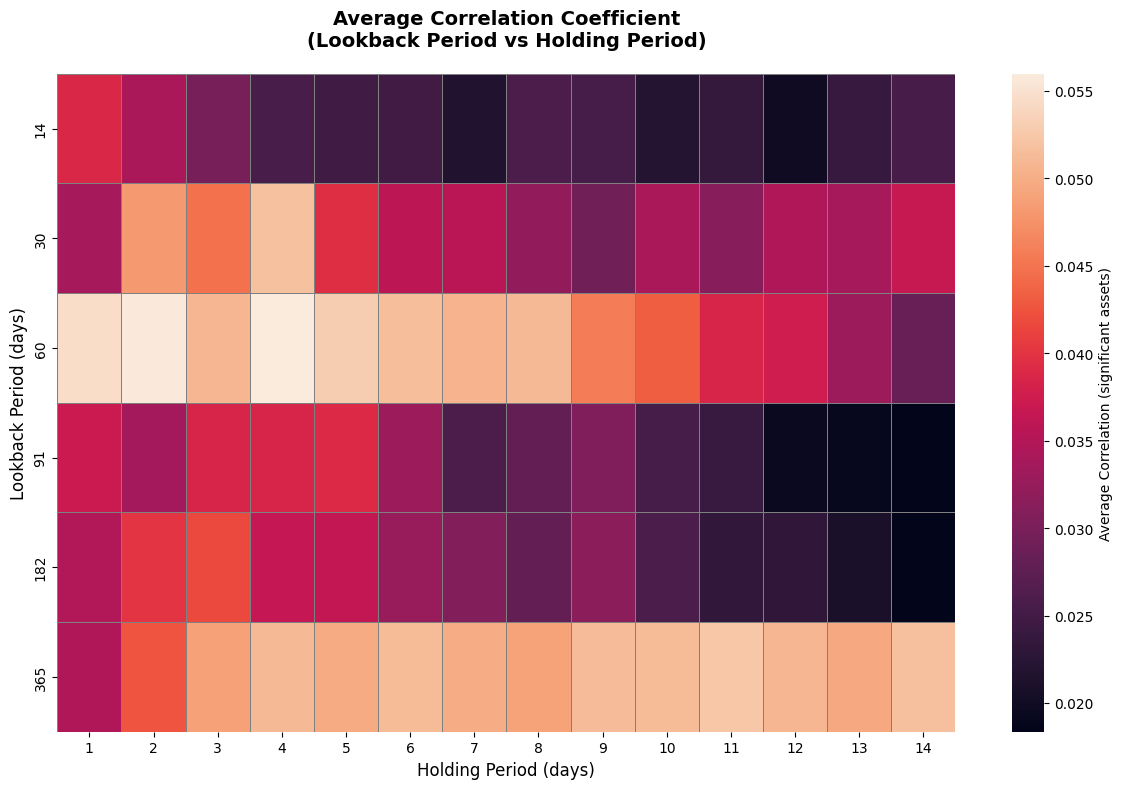

In [12]:
heatmap_data = results.pivot(index='lookback_period', 
                              columns='holding_period', 
                              values='correlation_coefficient')

# Create the heatmap with proper color scheme
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, 
            cmap='rocket',  # Purple (low) to white/cream (high)
            cbar_kws={'label': 'Average Correlation (significant assets)'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Average Correlation Coefficient\n(Lookback Period vs Holding Period)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Holding Period (days)', fontsize=12)
plt.ylabel('Lookback Period (days)', fontsize=12)
plt.tight_layout()
plt.savefig('q15_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


**Q16** What are the values of `lookback` and `hold` that may give a good trend following strategy?

Lookback: 60 days (2 months)  
Hold: 1 to 5 days

**Q17** Repeat the previous question using separately the first 24 columns of data, then the remaining columns.

In [13]:
split_point = 24
block1_assets = log_returns.columns[:split_point]
block2_assets = log_returns.columns[split_point:]

In [14]:
log_returns_block1 = log_returns[block1_assets]
results_block1 = pd.DataFrame(columns=['lookback_period', 'holding_period', 'correlation_coefficient'])

print("\nComputing correlations for Block 1...")
for hold in tqdm(range(1, 15), desc="Block 1"):
    for lookback in [14, 30, 60, 91, 182, 365]:
        rhos, pvalues = get_correlations(log_returns_block1, hold, lookback)
        correlations = pd.DataFrame({'rho': rhos, 'pvalue': pvalues}, index=log_returns_block1.columns)
        valid = correlations[correlations['pvalue'] < 0.1]
        results_block1.loc[len(results_block1)] = {
            'lookback_period': lookback,
            'holding_period': hold, 
            'correlation_coefficient': valid['rho'].mean()
        }


Computing correlations for Block 1...


Block 1: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Text(50.722222222222214, 0.5, 'Lookback Period (days)')

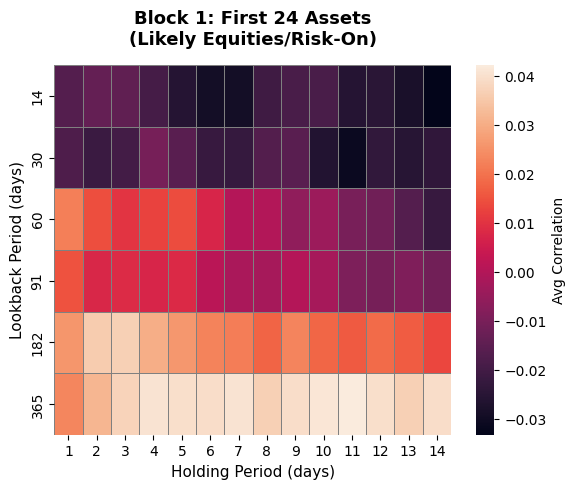

In [16]:
heatmap_data_block1 = results_block1.pivot(index='lookback_period', 
                                            columns='holding_period', 
                                            values='correlation_coefficient')

sns.heatmap(heatmap_data_block1,
            cmap='rocket',
            cbar_kws={'label': 'Avg Correlation'},
            linewidths=0.5,
            linecolor='gray',
            )

plt.title('Block 1: First 24 Assets\n(Likely Equities/Risk-On)', 
                  fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Holding Period (days)', fontsize=11)
plt.ylabel('Lookback Period (days)', fontsize=11)

In [17]:
log_returns_block2 = log_returns[block2_assets]
results_block2 = pd.DataFrame(columns=['lookback_period', 'holding_period', 'correlation_coefficient'])

print("\nComputing correlations for Block 2...")
for hold in tqdm(range(1, 15), desc="Block 2"):
    for lookback in [14, 30, 60, 91, 182, 365]:
        rhos, pvalues = get_correlations(log_returns_block2, hold, lookback)
        correlations = pd.DataFrame({'rho': rhos, 'pvalue': pvalues}, index=log_returns_block2.columns)
        valid = correlations[correlations['pvalue'] < 0.1]
        results_block2.loc[len(results_block2)] = {
            'lookback_period': lookback,
            'holding_period': hold, 
            'correlation_coefficient': valid['rho'].mean()
        }



Computing correlations for Block 2...


Block 2: 100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Text(50.722222222222214, 0.5, 'Lookback Period (days)')

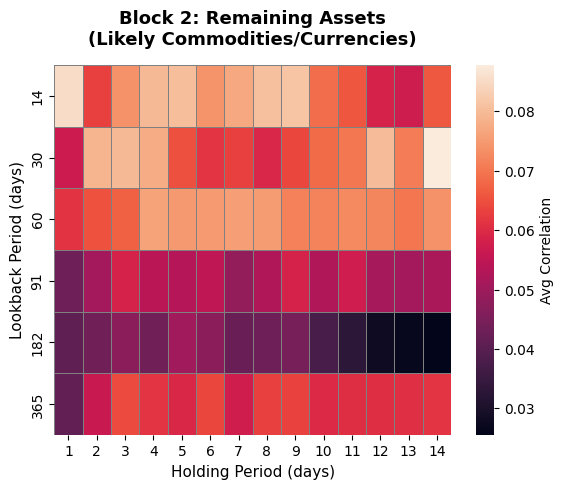

In [18]:
heatmap_data_block2 = results_block2.pivot(index='lookback_period', 
                                            columns='holding_period', 
                                            values='correlation_coefficient')

sns.heatmap(heatmap_data_block2,
            cmap='rocket',
            cbar_kws={'label': 'Avg Correlation'},
            linewidths=0.5,
            linecolor='gray',
            )

plt.title('Block 2: Remaining Assets\n(Likely Commodities/Currencies)', 
                  fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Holding Period (days)', fontsize=11)
plt.ylabel('Lookback Period (days)', fontsize=11)

**Q17** For each perimeter of assets, what are the best values?

In [19]:
max_corr_b1 = results_block1['correlation_coefficient'].max()
optimal_b1 = results_block1[results_block1['correlation_coefficient'] == max_corr_b1].iloc[0]

print(f"\n🎯 BLOCK 1 (Equities/Risk-On):")
print(f"   Optimal Lookback: {int(optimal_b1['lookback_period'])} days")
print(f"   Optimal Hold: {int(optimal_b1['holding_period'])} days")
print(f"   Maximum Correlation: {optimal_b1['correlation_coefficient']:.6f}")

top_5_b1 = results_block1.nlargest(5, 'correlation_coefficient')
print(f"\n   Top 5 combinations:")
for i, (idx, row) in enumerate(top_5_b1.iterrows(), 1):
    print(f"   {i}. Lookback={int(row['lookback_period']):3d}, Hold={int(row['holding_period']):2d} → ρ={row['correlation_coefficient']:.6f}")



🎯 BLOCK 1 (Equities/Risk-On):
   Optimal Lookback: 365 days
   Optimal Hold: 11 days
   Maximum Correlation: 0.042254

   Top 5 combinations:
   1. Lookback=365, Hold=11 → ρ=0.042254
   2. Lookback=365, Hold=10 → ρ=0.041194
   3. Lookback=365, Hold= 4 → ρ=0.040751
   4. Lookback=365, Hold= 7 → ρ=0.040529
   5. Lookback=365, Hold= 5 → ρ=0.039857


In [20]:
max_corr_b2 = results_block2['correlation_coefficient'].max()
optimal_b2 = results_block2[results_block2['correlation_coefficient'] == max_corr_b2].iloc[0]

print(f"\n🎯 BLOCK 2 (Commodities/Currencies):")
print(f"   Optimal Lookback: {int(optimal_b2['lookback_period'])} days")
print(f"   Optimal Hold: {int(optimal_b2['holding_period'])} days")
print(f"   Maximum Correlation: {optimal_b2['correlation_coefficient']:.6f}")

top_5_b2 = results_block2.nlargest(5, 'correlation_coefficient')
print(f"\n   Top 5 combinations:")
for i, (idx, row) in enumerate(top_5_b2.iterrows(), 1):
    print(f"   {i}. Lookback={int(row['lookback_period']):3d}, Hold={int(row['holding_period']):2d} → ρ={row['correlation_coefficient']:.6f}")



🎯 BLOCK 2 (Commodities/Currencies):
   Optimal Lookback: 30 days
   Optimal Hold: 14 days
   Maximum Correlation: 0.087773

   Top 5 combinations:
   1. Lookback= 30, Hold=14 → ρ=0.087773
   2. Lookback= 14, Hold= 1 → ρ=0.085124
   3. Lookback= 14, Hold= 9 → ρ=0.081244
   4. Lookback= 14, Hold= 8 → ρ=0.080684
   5. Lookback= 14, Hold= 5 → ρ=0.080378


**Q17** In the zone of parameters where trend following is not suitable, what is the sign of the correlation? 

In [21]:
negative_b1 = results_block1[results_block1['correlation_coefficient'] < 0]
negative_b2 = results_block2[results_block2['correlation_coefficient'] < 0]

print(f"\n📉 BLOCK 1 - Negative Correlations:")
if len(negative_b1) > 0:
    print(f"   Found {len(negative_b1)} parameter combinations with negative correlation")
    print(f"   Average negative correlation: {negative_b1['correlation_coefficient'].mean():.6f}")
    print(f"\n   Typical negative zones:")
    for idx, row in negative_b1.nsmallest(3, 'correlation_coefficient').iterrows():
        print(f"   • Lookback={int(row['lookback_period']):3d}, Hold={int(row['holding_period']):2d} → ρ={row['correlation_coefficient']:.6f}")
else:
    print("   No negative correlations found - all zones show positive momentum")

print(f"\n📉 BLOCK 2 - Negative Correlations:")
if len(negative_b2) > 0:
    print(f"   Found {len(negative_b2)} parameter combinations with negative correlation")
    print(f"   Average negative correlation: {negative_b2['correlation_coefficient'].mean():.6f}")
    print(f"\n   Typical negative zones:")
    for idx, row in negative_b2.nsmallest(3, 'correlation_coefficient').iterrows():
        print(f"   • Lookback={int(row['lookback_period']):3d}, Hold={int(row['holding_period']):2d} → ρ={row['correlation_coefficient']:.6f}")
else:
    print("   No negative correlations found - all zones show positive momentum")



📉 BLOCK 1 - Negative Correlations:
   Found 42 parameter combinations with negative correlation
   Average negative correlation: -0.017220

   Typical negative zones:
   • Lookback= 14, Hold=14 → ρ=-0.033132
   • Lookback= 30, Hold=11 → ρ=-0.031063
   • Lookback= 14, Hold= 6 → ρ=-0.029271

📉 BLOCK 2 - Negative Correlations:
   No negative correlations found - all zones show positive momentum


**Q17** Conclude on the type of strategy.

## 3- Strategy

We will develop the first trend following strategy based on the time-series momentum found above. We will use all possible values of lookback beween 2 weeks and 2 months with a step of 1 day. We will consider that the signal is the average of the obtained signs for all the lookback periods. For each asset, the signal will thus be between -1 and +1. **Q18** In the code below complete line 1 for the signal calculation.

In a first trading logic, we allocate on each day a given capital of 1 USD in the long and 1 USD in the short portfolio. The USD position shall be proportional to the signal value. **Q19** On line 2 and 3, fill the computation of the position suggested by this trading logic.

In [26]:
def compute_positions_trend(returns, periods_long):    
    signal = 0 * returns.fillna(0)
    for period in periods_long:
        return_sign = np.sign(returns.rolling(window=period).sum().shift(1))  # line 1
        signal = signal + return_sign
    signal = signal / len(periods_long)
    print(signal.shape)
    total_allocated = signal.abs().sum(axis=1)  # line 2
    position = signal.div(total_allocated, axis=0)  # line 3
    
    print(total_allocated.shape)
    print(position.shape)
    return position


In [22]:
def compute_positions_trend(returns, periods_long):    
    signal = 0 * returns.fillna(0)
    for period in periods_long:
        return_sign = # your code here  # line 1
        signal = signal + return_sign
    signal = signal / len(period)
    
    total_allocated = # your code line 2
    position = # your code line 3
    
    return position

SyntaxError: invalid syntax (347514286.py, line 4)

**Q20** What are the shapes of the dataframes `signal`, `allocate` and `position`?

The shapes of the dataframes `signal`, `allocate`, and `position` are all (3400, 47).

In [27]:
pos = compute_positions_trend(log_returns, periods_long=[30, 60, 90])


(8398, 47)
(8398,)
(8398, 47)


In order to simulate the returns of the trading strategy, we will invest each day with the positions suggested by the algorithm 2 days before. **Q21** Compute and plot the cumulated returns of the strategy.

In [1]:
# your code here

In section 2 the data was split between 2 groups of assets. Do the same and plot separately the cumulated returns for each group. **Q22** What can you say?

For the 1st group of assets repeat the same the strategy using a lookback window between 2 months and one year with a step of 10 days. **Q23** Use a delay of 1 week for trading the suggested position.

You have now 2 long-term trend following strategies with a lookback adapted to 2 classes of asset. Use the same logic with lookback values between 2 days and 2 weeks with a daily step and a trading delay of 2 days. **Q24** What can you say for the 2 groups of assets?

**Q25** Combine the 4 variants of the initial strategy into one strategy and plot its cumulated returns (not compounded). Compute its Sharpe ratio using the APR (on a 365-day basis) and daily volatility (on a 262-day basis).

### 4- Improvements

The base strategy is now combining long-term and short-term signals for 2 groups of assets in an equal allocation logic. Try to improve this baseline using the following ideas:
- exclude from the contributing `return_sign` the ones that are very close to zero using a test that should not depend on the volatility or the look-back period
- use only signals that are strong enough (expression shown in CM3 or threshold method from TP3)
- cite and use other types of allocation
- propose other improvements, for example using the moving average signal instead of the time series momentum, the FIP signal shown in CM2 or other technical indicators (RSI, Hurst exponent...)
- explore ML techniques like gradient boosted trees.

These suggestions are cited to guide your choice. It is not expected that you try everything listed above!